In [2]:
import enspp.bma as bma
import enspp.vis as vis
from enspp.util import _get_r_module, _fxda

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wrfpywind import data_preprocess as pp
import xarray as xr
import time

In [4]:
# Read in the observational data
obs = pp.fmt_buoy_wspd(
                       data_path='/share/mzhang/jas983/wrf_data/oshwind/wrfpywind/wrfpywind/data/nyserda_buoy/', 
                       south_dates_str='20190904_20210207', north_dates_str='20190812_20210207', 
                       heights=[20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
                       start_date='12-01-2019', end_date='12-31-2019')

In [5]:
# Specify the forecast initialization time
t_init = '2019-12-08'

In [4]:
# Fit the BMA model using two historical simulations
fit = bma.read_fmt_fit_bma(t_init, obs, n_days=2, datadir='../data/')

In [6]:
# Read in the ensemble data that you want to correct using BMA
t_init = pd.to_datetime(t_init)
t_end = t_init + pd.DateOffset(days=4)
# Open the xarray Dataset contianing wind speed data for the entire domain 
# note that you must use a `Dataset` object for the `extract_buoy_da` function to work.
ensds = xr.open_dataset(f"../data/ensds_{t_init.strftime('%Y%m%d')}-{t_end.strftime('%d')}.nc")

In [7]:
# Read the R gamma_bma module into Python
gamma_bma = _get_r_module('../R/gamma_bma.r', 'gamma_bma')

In [8]:
# Select only the height that we are interested in
wrfda = ensds.wspd_wrf.sel(height=100)
obsda = obs
quantiles=np.arange(0.01, 1, 0.01)

In [14]:
wrfda_slice = wrfda.sel(Time=slice('2019-12-11 12:40', '2019-12-11 12:40'))

In [15]:
wrfda_slice

<xarray.DataArray 'wspd_wrf' (model: 5, Time: 1, south_north: 180, west_east: 189)>
[170100 values with dtype=float32]
Coordinates:
    XTIME    (Time) float32 ...
    XLONG    (south_north, west_east) float32 -74.41 -74.4 ... -72.14 -72.13
    XLAT     (south_north, west_east) float32 39.36 39.36 39.36 ... 40.92 40.92
  * Time     (Time) datetime64[ns] 2019-12-11T12:40:00
  * model    (model) object 'Lee 2017' 'Draxl 2014a' ... 'Optis 2021'
    height   int64 100
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:   104
    units:       m s-1
    stagger:     
    projection:  LambertConformal(stand_lon=-76.0, moad_cen_lat=41.5000076293...
    vert_units:  m

In [9]:
wrfda_slice.to_dataframe().wspd_wrf

model       Time        south_north  west_east
Lee 2017    2019-12-12  0            0             9.970822
                                     1             9.942835
                                     2             9.946613
                                     3             9.981493
                                     4            10.044352
                                                    ...    
Optis 2021  2019-12-12  179          184           8.196187
                                     185           8.267203
                                     186           8.335066
                                     187           8.398745
                                     188           8.458690
Name: wspd_wrf, Length: 170100, dtype: float32

In [109]:
# Now, extract a the full grid for a single time slice and make it so that each ensemble member still contains's it's own column
# Note -- should still format the time variable here
XLAT = wrfda_slice.to_dataframe().XLAT.unstack(0).iloc[:,0].rename('XLAT')
XLONG = wrfda_slice.to_dataframe().XLONG.unstack(0).iloc[:,0].rename('XLONG')
wspdgrid_unstacked = wrfda_slice.to_dataframe().wspd_wrf.unstack(0)
wspdgrid = pd.concat([wspdgrid_unstacked, XLAT, XLONG], axis=1).reset_index(['south_north', 'west_east'], drop=True).reset_index('Time')
wspdgrid

,Time,Lee 2017,Draxl 2014a,Draxl 2014b,Veron 2018,Optis 2021,XLAT,XLONG
0,2019-12-12,9.970822,10.653820,10.843820,10.763190,11.505099,39.361187,-74.406677
1,2019-12-12,9.942835,10.720985,10.795059,10.694288,11.472770,39.361023,-74.395020
2,2019-12-12,9.946613,10.783429,10.723203,10.585211,11.445001,39.360859,-74.383423
3,2019-12-12,9.981493,10.838778,10.625975,10.426066,11.436303,39.360687,-74.371765
4,2019-12-12,10.044352,10.888151,10.510357,10.225752,11.437304,39.360519,-74.360168
...,...,...,...,...,...,...,...,...
34015,2019-12-12,8.475451,10.778838,10.729612,10.195070,8.196187,40.918777,-72.176666
34016,2019-12-12,8.609872,10.832775,10.869427,10.365176,8.267203,40.918377,-72.164764
34017,2019-12-12,8.742513,10.871990,10.996819,10.505319,8.335066,40.917980,-72.152863
34018,2019-12-12,8.872252,10.894163,11.118521,10.615445,8.398745,40.917580,-72.140991


In [31]:
# Extract the quantiles using the BMA test fit -- this now takes ~10min for 99 quantiles
q = gamma_bma.quant_bma(fit, wspdgrid, n_ens_members=5, quantiles=np.array([0.1, 0.5, 0.9]), type='spatial')

In [32]:
q.shape

(34020, 3)

In [155]:
# Use the multi-index from the unstacked version of the gridded DataFrame to create the new DataFrame
fx = pd.DataFrame(q, index=wspdgrid_unstacked.index, columns=np.array([10, 50, 90]))
# Stack the percentiles into the multi-index
fx = fx.stack(dropna=False)
# Convert the pd.DataFrame to a xr.DataArray
fx = fx.to_xarray()
# Rename the dimension that pandas created when stacking the percentiles
fx = fx.rename({'level_3':'Percentile'})
# Add the latitude and longitude information back to the DataArray
fx = fx.assign_coords(XLONG=(['south_north', 'west_east'], wrfda_slice.XLONG.values))
fx = fx.assign_coords(XLAT=(['south_north', 'west_east'], wrfda_slice.XLAT.values))
fx

<xarray.DataArray (Time: 1, south_north: 5, west_east: 5, Percentile: 3)>
array([[[[11.49995474, 14.36298511, 17.65376406],
         [11.47946679, 14.33835241, 17.62700382],
         [11.46221102, 14.31767196, 17.60452276],
         [11.46023885, 14.31376186, 17.59948846],
         [11.46592862, 14.31825116, 17.60320422]],

        [[11.35854917, 14.22179352, 17.51397606],
         [11.35861834, 14.21837553, 17.50871779],
         [11.36016207, 14.21674714, 17.50536103],
         [11.36457098, 14.21889178, 17.50620828],
         [11.36521469, 14.21743977, 17.50357191]],

        [[11.25476437, 14.12206682, 17.41719898],
         [11.26984007, 14.13265435, 17.42547277],
         [11.29081379, 14.15017951, 17.44103758],
         [11.30077754, 14.1572121 , 17.44642808],
         [11.30314096, 14.15718701, 17.4450999 ]],

        [[11.21044933, 14.08976679, 17.39072494],
         [11.24316486, 14.11410169, 17.41108065],
         [11.25774506, 14.12237916, 17.4162405 ],
         [11.26300453, 14.12291157, 17.41437476],
         [11.25644887, 14.11216786, 17.40152615]],

        [[11.1478955 , 14.02846135, 17.33034498],
         [11.18836901, 14.06332088, 17.3625335 ],
         [11.27577264, 14.15029702, 17.44873125],
         [11.31491106, 14.18620442, 17.48286534],
         [11.3003887 , 14.16526646, 17.45894851]]]])
Coordinates:
  * Time         (Time) datetime64[ns] 2019-12-12
  * south_north  (south_north) int64 0 1 2 3 4
  * west_east    (west_east) int64 0 1 2 3 4
  * Percentile   (Percentile) int64 10 50 90

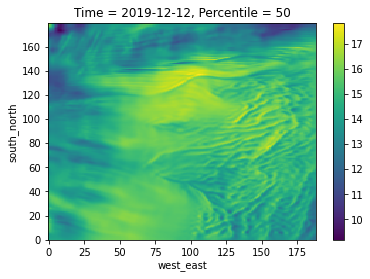

In [156]:
fx.sel(Percentile=50).plot()